グラフの応用
==========

前章では基本的なグラフの操作方法について学びました。
今回は、実際のデータを使ってグラフを分析していきましょう。

使うデータセットは`Zachary's Karate Club`といい、人間関係ネットワークです。

このデータの特徴は以下の通りです。

- 海外の大学の空手クラブで２人のリーダーが仲間割れしたときの内部の人間関係
- 部員をノード、交友関係をエッジとして表している
- ノードは34個、エッジは78本です
- ノードIDが0は空手クラブの会長、ノードIDが33はインストラクターです
- ノードは、会長派とインストラクター派に分かれています

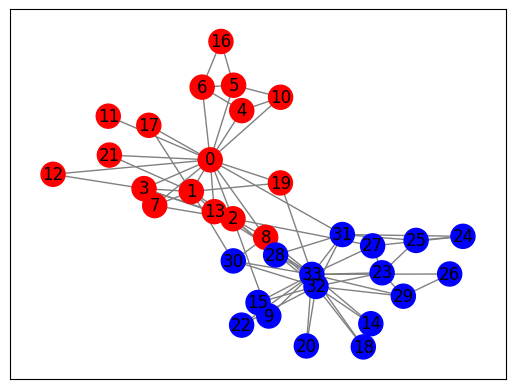

In [1]:
import networkx as nx

G = nx.karate_club_graph()

true_labels = [G.nodes[n]['club'] for n in G.nodes()]
color_map = {'Mr. Hi': 'red', 'Officer': 'blue'}
node_colors = [color_map[label] for label in true_labels]

pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, node_color=node_colors, edge_color='gray')

プログラムでこのネットワークの状況を表示しました。
このプログラムについて説明します。

1行目でnetworkxをインポートしています。networkxはnxとよく省略されます。
3行目はnetworkxで準備されているkarate clubの情報をGという変数名で指すようにしています。

5行目はそれぞれのノードの属性を取り出しています。
`Mr. Hi`がインストラクター派、`Officer`が会長派になります。

6、7行目はノードの属性を元にグラフでの色付けを決めています。

では、このグラフからノードとエッジの情報のみを使って重要人物を考えたり、
どのノードが会長派なのかを予測してみましょう。

重要人物を考えるには、前章で学んだ中心性が使えるかもしれません。

それぞれの中心性を求めて、上位2名を見てみましょう。

In [2]:
c0 = nx.degree_centrality(G)
c1 = nx.closeness_centrality(G)
c2 = nx.betweenness_centrality(G)
c3 = nx.eigenvector_centrality(G)

print(sorted(c0.items(), key=lambda x: -x[1])[0:2])
print(sorted(c1.items(), key=lambda x: -x[1])[0:2])
print(sorted(c2.items(), key=lambda x: -x[1])[0:2])
print(sorted(c3.items(), key=lambda x: -x[1])[0:2])

[(33, 0.5151515151515151), (0, 0.48484848484848486)]
[(0, 0.5689655172413793), (2, 0.559322033898305)]
[(0, 0.43763528138528146), (33, 0.30407497594997596)]
[(33, 0.37337121301323506), (0, 0.35548349418519426)]


多くの中心性で会長とインストラクターは重要だとわかります。
ただ、近接中心性にはインストラクターが入ってません。
この結果から何が言えるか、考えてみるとよいでしょう。

## 最短経路

では、部員を派閥に分ける方法について考えてみましょう。
たとえば、その部員から会長へ最短パスとインストラクターへの最短パスを求めて、より小さい方の派閥であると考えるのはどうでしょうか？

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate

# 会長とインストラクターへの最短パス距離を計算
president_paths = nx.shortest_path_length(G, target=0)
instructor_paths = nx.shortest_path_length(G, target=33)

# 結果を格納するデータフレームを作成
results = []

# 各ノードについて情報を収集
for node in G.nodes():
    # 予測派閥を決定
    if president_paths[node] < instructor_paths[node]:
        predicted_label = 'Mr. Hi'
    else:
        predicted_label = 'Officer'
    
    # 実際の派閥と一致するかどうか
    is_correct = predicted_label == true_labels[node]
    
    # 結果をリストに追加
    results.append({
        'ノード': node,
        '会長までの距離': president_paths[node],
        'インストラクターまでの距離': instructor_paths[node],
        '予測派閥': predicted_label,
        '実際の派閥': true_labels[node],
        '正誤': '正' if is_correct else '誤'
    })

# データフレームに変換
df = pd.DataFrame(results)

# 表として表示
print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

# 正確度を計算
correct = sum(1 for i, j in zip(df['予測派閥'], true_labels) if i == j)
accuracy = correct / len(G.nodes())
print(f"\n予測精度: {correct}/{len(G.nodes())} = {accuracy:.2%}")

╒══════════╤══════════════════╤══════════════════════════════╤════════════╤══════════════╤════════╕
│   ノード │   会長までの距離 │   インストラクターまでの距離 │ 予測派閥   │ 実際の派閥   │ 正誤   │
╞══════════╪══════════════════╪══════════════════════════════╪════════════╪══════════════╪════════╡
│        0 │                0 │                            2 │ Mr. Hi     │ Mr. Hi       │ 正     │
├──────────┼──────────────────┼──────────────────────────────┼────────────┼──────────────┼────────┤
│        1 │                1 │                            2 │ Mr. Hi     │ Mr. Hi       │ 正     │
├──────────┼──────────────────┼──────────────────────────────┼────────────┼──────────────┼────────┤
│        2 │                1 │                            2 │ Mr. Hi     │ Mr. Hi       │ 正     │
├──────────┼──────────────────┼──────────────────────────────┼────────────┼──────────────┼────────┤
│        3 │                1 │                            2 │ Mr. Hi     │ Mr. Hi       │ 正     │
├──────────┼──────────────────┼───────

3名しか間違ってないですね。他にも自分なりの方法で考えてみましょう。

## コミュニティ検出

コミュニティ検出とは、ネットワークの中で、お互いに強く結びついているグループを見つけ出す方法です。
今回のように部員同士の繋がりからグループを分類するタスクにぴったりの方法になります。

ここで、コミュニティ検出で重要な考え方であるモジュラリティについて説明します。
モジュラリティは、見つけたグループが「**どれだけ**良いグループか」を数値で表しています。

良いグループとは

1. グループ内の人たちは互いによく繋がっている
2. 異なるグループ間の繋がりは少ない

と考え、数式で表すと以下のようになるでしょう。

$$Q = \frac{1}{2m}\sum_{i,j} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)$$

- $A_{ij}$ はノード$i$と$j$の間に繋がりがあれば1、なければ0
- $k_i$ はノード$i$の繋がりの数
- $m$ はネットワーク全体の繋がりの総数
- $c_i$ はノード$i$が属するコミュニティ
- $\delta(c_i, c_j)$ は$i$と$j$が同じコミュニティなら1、違えば0

難しく見えますが、要するに「実際の繋がり」と「ランダムな場合に予想される繋がり」の差を計算していて、この値が大きいほど良いグループ分けができているといえます。

このモジュラリティを最大化するようにグラフを分ける方法がLouvain法になります。

Louvain法のアルゴリズムは、

```{prf:algorithm} Louvain法
:label: louvain-algo
**入力:** グラフ

**出力:** 分類されたグラフ

1. 最初、全てのノードを別々のコミュニティとする
2. 各ノードを隣接するコミュニティに移動させてみて、モジュラリティが上がれば移動を確定
3. コミュニティを一つのノードにまとめる
4. モジュラリティが上がらなくなるまで2と3を繰り返す
```

こうして自然なグループ分けができるのです。

では実際にLouvain法を使って`Karate Club`をグループ分けしてみましょう。

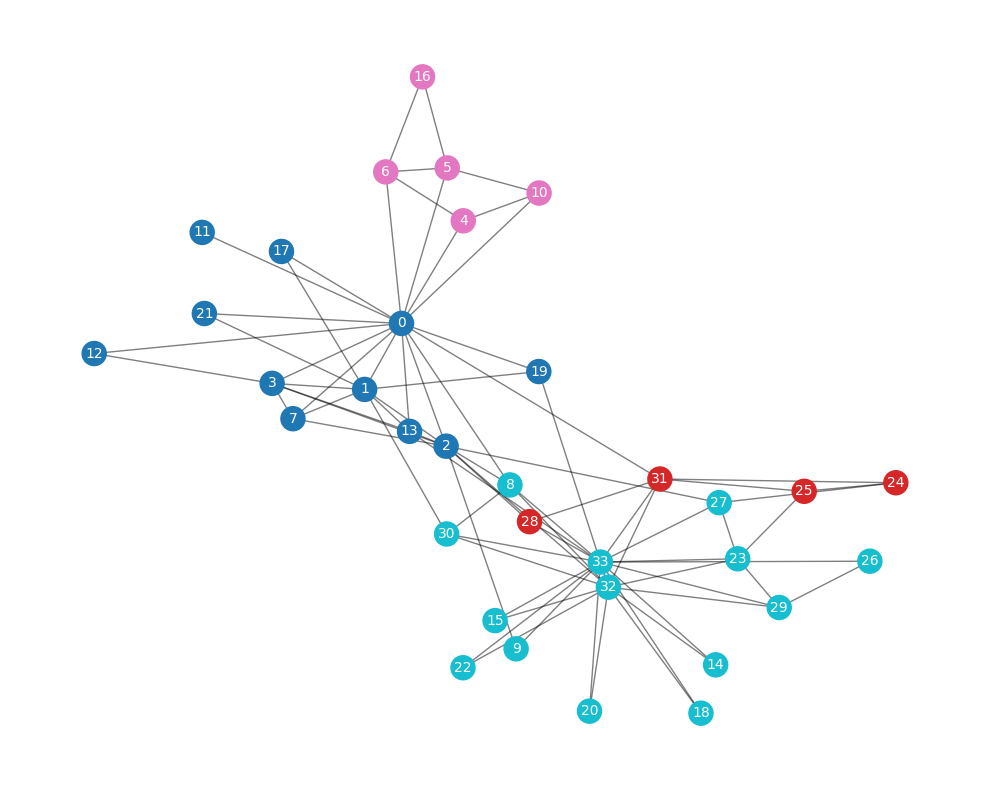

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from community.community_louvain import best_partition

# カラテクラブグラフを生成
G = nx.karate_club_graph()

# Louvain法によるコミュニティ検出
partition = best_partition(G)
louvain_labels = [partition[node] for node in G.nodes()]

# 検出されたコミュニティに基づいてノードに色を付ける
colors = [partition[node] for node in G.nodes()]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # レイアウトを固定するためにシードを設定
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.cm.tab10, node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="white")

plt.axis('off')
plt.tight_layout()
plt.show()

コミュニティが4つできましたね。
正解は2つなので、4つから2つに直して正解率を出してみましょう。

In [5]:
unique_communities = set(louvain_labels)
if len(unique_communities) > 2:
    # コミュニティサイズを計算
    community_sizes = {}
    for comm in unique_communities:
        community_sizes[comm] = louvain_labels.count(comm)
    
    # 上位2つのコミュニティを残す
    top_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:2]
    top_comm_ids = [comm[0] for comm in top_communities]
    
    # 残りのコミュニティを最も近いトップコミュニティに割り当て
    for i, label in enumerate(louvain_labels):
        if label not in top_comm_ids:
            # 最も近いトップコミュニティに割り当て
            connections = []
            for top_comm in top_comm_ids:
                count = 0
                for neighbor in G.neighbors(i):
                    if louvain_labels[neighbor] == top_comm:
                        count += 1
                connections.append((top_comm, count))
            
            best_match = max(connections, key=lambda x: x[1])[0]
            louvain_labels[i] = best_match

# ラベルをバイナリに変換（0と1のみに）
louvain_unique = list(set(louvain_labels))
louvain_binary = [louvain_unique.index(label) for label in louvain_labels]
true_labels = [1 if G.nodes[node]['club'] == 'Officer' else 0 for node in G.nodes()]

correct_0 = sum(1 for i, j in zip(louvain_binary, true_labels) if i == 0 and j == 0)
correct_1 = sum(1 for i, j in zip(louvain_binary, true_labels) if i == 0 and j == 1)

if correct_1 > correct_0:
    louvain_binary = [1 - label for label in louvain_binary]

accuracy = sum(1 for i, j in zip(louvain_binary, true_labels) if i == j) / len(true_labels)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9706


## グラフ埋め込み

Word2Vecの考え方をグラフに適応した方法がDeepWalkで、
ランダムウォークを使ってグラフを文のように扱えばノードは単語となり、
Word2Vecを使うことでノードのベクトル表現が得られるという発想です。

まずはグラフ上でランダムウォークを実行してみましょう。

Steps in random walk: [6, 4, 0, 5, 10, 0, 7, 1, 3, 12, 3, 2, 8, 32, 2, 13, 2, 13, 2, 0, 12]


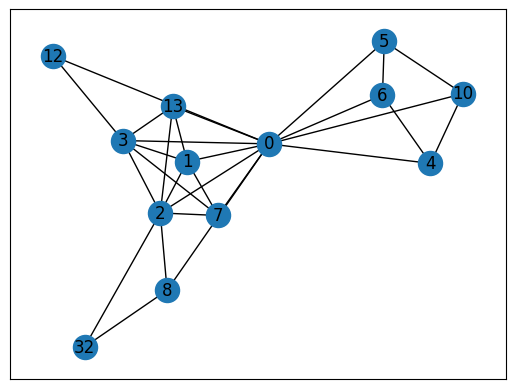

In [6]:
import random

def random_walk(G, start_node, walk_length):
    """グラフ上でランダムウォークを実行し、ノードの系列を生成"""
    walk = [start_node]
    
    for i in range(walk_length):
        current_node = walk[-1]
        neighbors = list(G.neighbors(current_node))
        next_node = random.choice(neighbors)
        walk.append(next_node)
    
    return walk

walk = random_walk(G, 6, 20)
print('Steps in random walk:', walk)

walk_graph = G.subgraph(walk)
pos = nx.spring_layout(walk_graph, seed=42)
nx.draw_networkx(walk_graph, pos=pos)

このプログラムでは、特定のノードから開始して、そのノードから移動できる（繋がっている）ノードに移動していき、
指定された個数のノードを移動したらランダムウォークを終了しています。

このようにして得られたノードの列を文として考えると、それぞれのノードは単語となり、
その系列をWord2Vecで学習すると、ノードのベクトル表現が得られます。

では、このベクトル表現を可視化してみましょう。

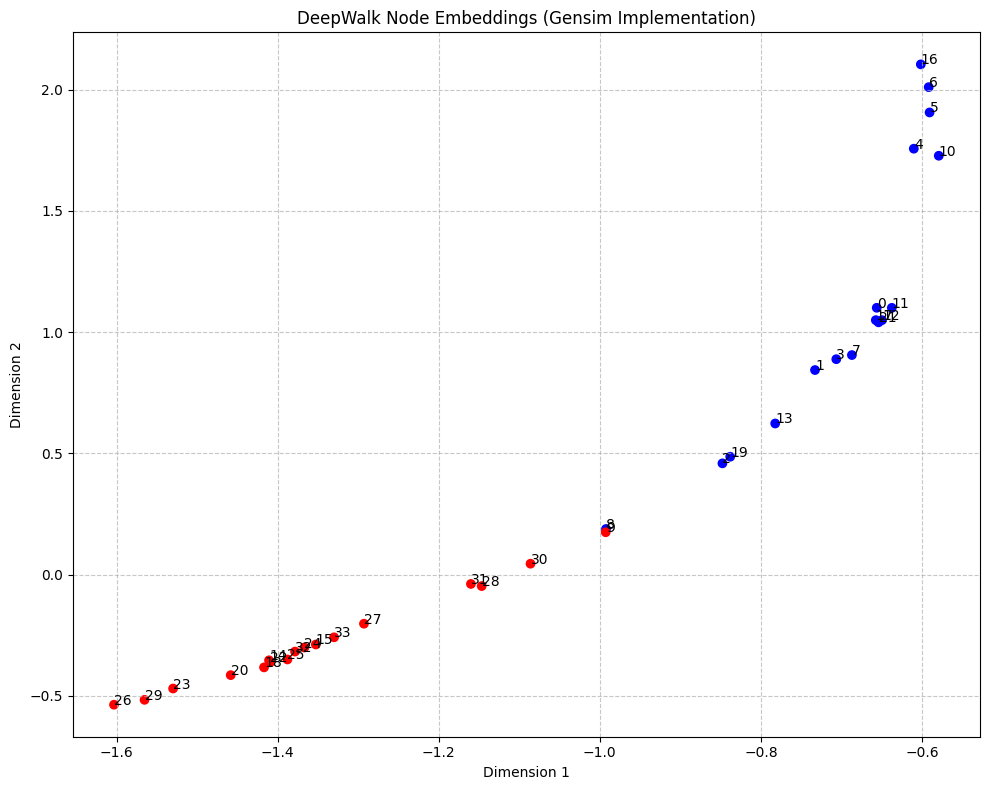

In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

np.random.seed(42)
random.seed(42)

def generate_walks(G, num_walks, walk_length):
    """全ノードからランダムウォークを複数回実行"""
    walks = []
    nodes = list(G.nodes())
    
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walks.append(random_walk(G, node, walk_length))
    
    return [list(map(str, walk)) for walk in walks]

def train_deepwalk_gensim(walks, vec_dim=2, window_size=2, epochs=5):
    """gensimのWord2Vecを使ってDeepWalkを学習"""
    # Word2Vecモデルの学習
    model = Word2Vec(sentences=walks, 
                    vector_size=vec_dim,
                    window=window_size,
                    min_count=0,
                    sg=1,
                    workers=4,
                    epochs=epochs)
    
    return model

def visualize_embeddings(G, model):
    """埋め込みを可視化"""
    plt.figure(figsize=(10, 8))
    
    # ノードの埋め込みベクトルを取得
    node_ids = list(G.nodes())
    node_embeddings = np.array([model.wv[str(node)] for node in node_ids])
    
    # クラブ属性に基づいて色を設定
    colors = ['r' if G.nodes[node].get('club') == 'Officer' else 'b' for node in node_ids]
    
    x, y = node_embeddings[:, 0], node_embeddings[:, 1]
    
    plt.scatter(x, y, c=colors)
    
    # ノード番号を表示
    for i, node in enumerate(node_ids):
        plt.annotate(str(node), (x[i], y[i]))
    
    plt.title('DeepWalk Node Embeddings (Gensim Implementation)')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def run_deepwalk(G, num_walks=30, walk_length=20, vec_dim=2, window_size=3, epochs=20):
    # ランダムウォークを生成
    walks = generate_walks(G, num_walks, walk_length)
    
    # Word2Vecで学習
    model = train_deepwalk_gensim(walks, vec_dim, window_size, epochs)
    
    # 埋め込みを可視化
    visualize_embeddings(G, model)
    
    return model

G = nx.karate_club_graph()
model = run_deepwalk(G)

実行結果の図を見ると、会長派とインストラクター派がそれぞれのグループに分かれていることがわかります。

プログラムの説明をします。

9行目の`generate_walks`は、全てのノードからランダムに1つのノードを選び、ランダムウォークを`num_walks`回実行して、ノードの系列を生成します。
19行目は、ノードの系列を文字列にしています。これは、Word2Vecの入力形式に合わせるためです。

21行目の`train_deepwalk_gensim`は、Word2Vecを学習する関数です。
`sentences`には、ノードの系列が入っています。
`vector_size`は、ノードのベクトル表現の次元数です。
今回はプロットしやすくするため、2次元にしています。

34行目の`visualize_embeddings`は、ノードのベクトル表現を可視化する関数です。40行目の`model.wv`でノードのベクトル表現を取得しています。

- 境界線を引いてみましょう。
- ノードの長さを変えるとどんな結果になりますか？
- Word2Vecの`vector_size`を変えて表示してみましょう。